In [1]:
import os.path as op
import scipy.io
import numpy as np
import mne
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from mne.channels import find_ch_adjacency
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial
import seaborn as sns

In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']
c_cluster_chans=['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51']

montage = mne.channels.make_standard_montage('GSN-HydroCel-64_1.0')
info = mne.create_info(montage.ch_names, 1000, 'eeg').set_montage(montage)

_channels = np.array([np.where(np.in1d(info.ch_names, ch))[0] for ch in c_cluster_chans])
c_mask = np.zeros(len(montage.ch_names), dtype='bool')
c_mask[_channels]=True

plags=[2, 3, 4]


/tmp/ipykernel_4476/3386069915.py:49: RuntimeWarning: Mean of empty slice
  mean_beta=np.nanmean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)


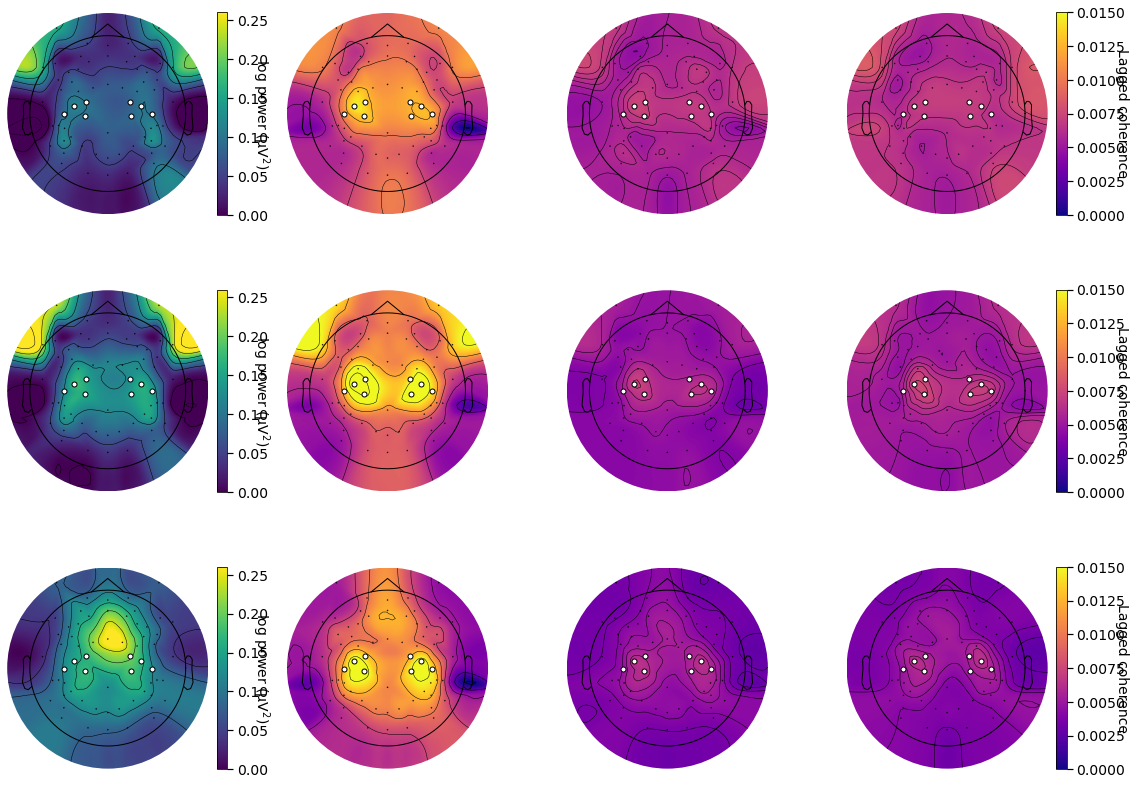

In [3]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages),4)

for age_idx, age in enumerate(ages):
    # Load PSD
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    periodic=f['periodic']
    periodic[periodic<0]=0
    frex=f['frex'][0,:]
    fois=f['foi_ranges']
    beta_idx=np.where(fois[:,1]<=30)[0][-1]
    beta1_range=fois[beta_idx,:]  
    
    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    lags=f['lags'][0,:]
    lagged_coh=f['lagged_coh']
    freq_idx=np.where((foi>=5) & (foi<=80))[0]
    foi=foi[freq_idx]
    lag_idx=np.where((lags<=4.5))[0]
    lags=lags[lag_idx]
    lagged_coh=lagged_coh[:,:,freq_idx,:]
    lagged_coh=lagged_coh[:,:,:,lag_idx]
    for s in range(lagged_coh.shape[0]):
        subj_lagged_coh=lagged_coh[s,:,:,:]
        lagged_coh[s,:,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])
    
    ax = fig.add_subplot(gs[age_idx, 0])
    frex_idx=np.where((frex>=beta1_range[0]) & (frex<=beta1_range[1]))[0]
    mean_beta=np.nanmean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)    
    tm,cm=plot_topomap(mean_beta,info,cmap='viridis',axes=ax,show=False,
                       mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'),vmin=0, vmax=.26)
    cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
    cbar.set_label('log power (µV$^2$)', rotation=270)
    
    foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
    for l in range(len(plags)):
        lag_idx=np.where((lags>=plags[l]) & (lags<=(plags[l]+.5)))[0]
        foi_idx=np.where((foi>=beta1_range[0]) & (foi<=beta1_range[1]))[0]
        flc=lagged_coh[:,:,foi_idx,:]
        flc=flc[:,:,:,lag_idx]
        flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
        foi_lc[:,l,:]=flc
    mean_foi_lc=np.nanmean(foi_lc,axis=0)
        
    for l in range(len(plags)):
        ax = fig.add_subplot(gs[age_idx, l+1])
        tm,cm=plot_topomap(mean_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=0, vmax=0.015,
                           mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
        cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
        if l<len(plags)-1:
            fig.delaxes(cbar.ax)
    cbar.set_label('Lagged coherence', rotation=270)
        
plt.tight_layout()

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure2.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure2.png')


Mu: 9m: 5.5 - 9.0 Hz


/tmp/ipykernel_4476/1704133674.py:32: RuntimeWarning: Mean of empty slice
  mean_pow=np.nanmean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)


Mu: 12m: 5.75 - 9.25 Hz
Mu: adult: 9.25 - 12.75 Hz


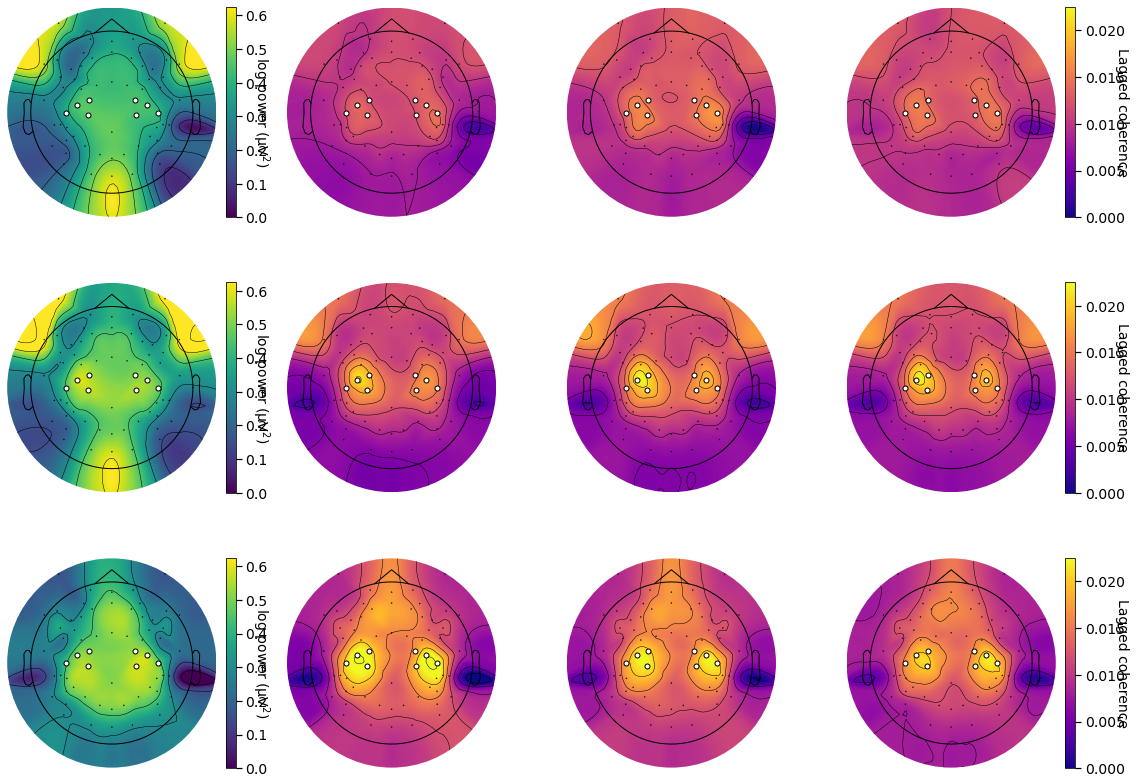

In [4]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages),4)

for age_idx, age in enumerate(ages):    
    # Load PSD
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    periodic=f['periodic']
    periodic[periodic<0]=0
    fois=f['foi_ranges']
    beta_idx=np.where(fois[:,1]<=30)[0][-1]
    band_range=fois[beta_idx-1]
    print('Mu: {}: {} - {} Hz'.format(age,band_range[0],band_range[1]))

    frex=f['frex'][0,:]
    frex_idx=np.where((frex>=band_range[0]) & (frex<=band_range[1]))[0]
    mean_pow=np.nanmean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)

    vmin=0
    vmax=0.625
    ax = fig.add_subplot(gs[age_idx, 0])
    tm,cm=plot_topomap(mean_pow,info,cmap='viridis',axes=ax,show=False,
                       mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'),
                       vmin=vmin, vmax=vmax)
    cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
    cbar.set_label('log power (µV$^2$)', rotation=270)

    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    foi_idx=np.where((foi>=band_range[0]) & (foi<=band_range[1]))[0]

    vmin=0
    vmax=0.0225
    
    if len(foi_idx):
        lags=f['lags'][0,:]
        lagged_coh=f['lagged_coh']

        lag_idx=np.where((lags<=4.5))[0]
        lags=lags[lag_idx]
        lagged_coh=lagged_coh[:,:,:,lag_idx]

        for s in range(lagged_coh.shape[0]):
            subj_lagged_coh=lagged_coh[s,:,:,:]
            lagged_coh[s,:,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])

        band_foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
        for l in range(len(plags)):
            lag_idx=np.where((lags>=plags[l]) & (lags<=(plags[l]+.5)))[0]            
            flc=lagged_coh[:,:,foi_idx,:]
            flc=flc[:,:,:,lag_idx]
            flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
            band_foi_lc[:,l,:]=flc

        mean_band_foi_lc=np.nanmean(band_foi_lc,axis=0)

        max_band_lc=np.max(mean_band_foi_lc[:])
        for l in range(len(plags)):
            ax = fig.add_subplot(gs[age_idx, l+1])
            tm,cm=plot_topomap(mean_band_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=vmin, vmax=vmax,
                           mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
            cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
            if l<len(plags)-1:
                fig.delaxes(cbar.ax)                
        cbar.set_label('Lagged coherence', rotation=270)

plt.tight_layout()

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure3.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure3.png')